In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

 I → Immature
M → Mature
S → Overmature

In [ ]:
!ls drive/MyDrive/dataset_cacao/

Testing  Training


##Definimos un tamaño para las imagenes


In [ ]:
image_size = (180, 180)
batch_size = 32
class_names=['cocoaI', 'cocoaM', 'cocoaS', 'notcocoa']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/dataset_cacao/Training",
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode="categorical",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size

)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/dataset_cacao/Training",
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode="categorical",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/dataset_cacao/Testing",
    #validation_split=0.2,
    #subset="validation",
    labels='inferred',
    label_mode="categorical",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 281 files belonging to 4 classes.
Using 225 files for training.
Found 281 files belonging to 4 classes.
Using 56 files for validation.
Found 24 files belonging to 4 classes.


#Aumentar Datos usando flip y rotation y Visualizamos

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


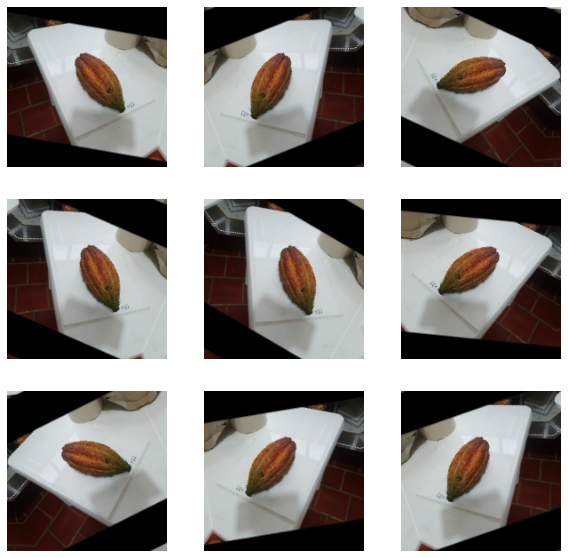

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##Estandarizando imagenes

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Configurando el Performance

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

##Construyendo el modelo

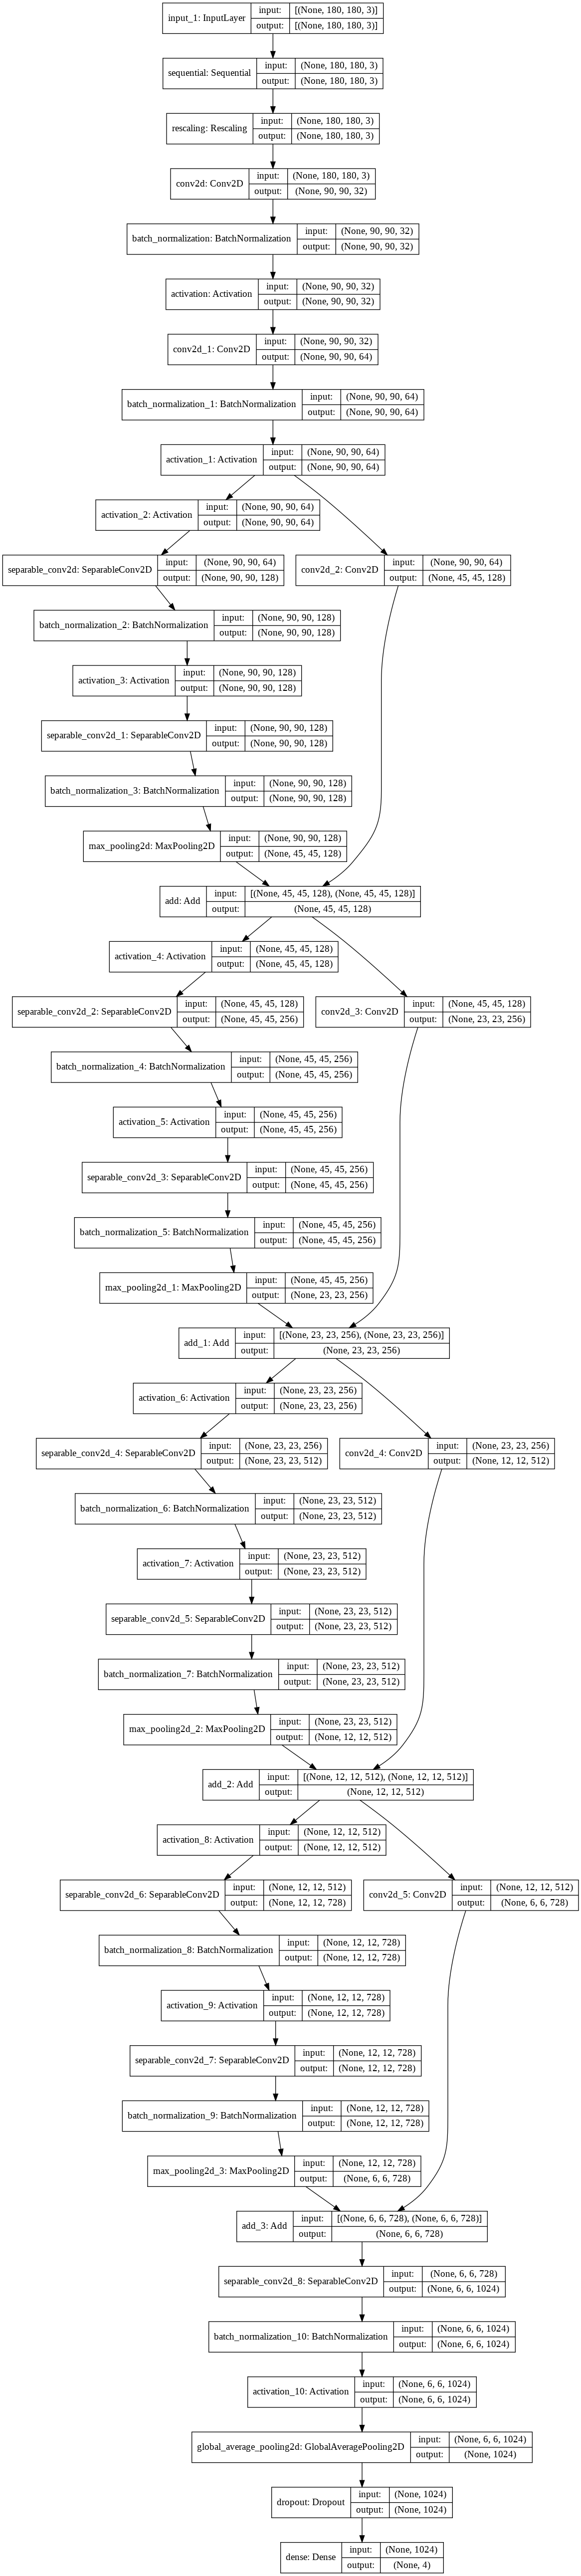

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

## Entrenando el modelo

In [ ]:
epochs = 180

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("saveat{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/180
8/8 [==============================] - 49s 2s/step - loss: 1.0871 - accuracy: 0.5689 - val_loss: 1.3810 - val_accuracy: 0.3036


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/180
8/8 [==============================] - 5s 469ms/step - loss: 0.5408 - accuracy: 0.7511 - val_loss: 1.3779 - val_accuracy: 0.3036
Epoch 3/180
8/8 [==============================] - 4s 454ms/step - loss: 0.4953 - accuracy: 0.7911 - val_loss: 1.3898 - val_accuracy: 0.3036
Epoch 4/180
8/8 [==============================] - 4s 456ms/step - loss: 0.4731 - accuracy: 0.7733 - val_loss: 1.3818 - val_accuracy: 0.3036
Epoch 5/180
8/8 [==============================] - 4s 454ms/step - loss: 0.3971 - accuracy: 0.8222 - val_loss: 1.4065 - val_accuracy: 0.2143
Epoch 6/180
8/8 [==============================] - 4s 459ms/step - loss: 0.3363 - accuracy: 0.8711 - val_loss: 1.4233 - val_accuracy: 0.2143
Epoch 7/180
8/8 [==============================] - 5s 459ms/step - loss: 0.2913 - accuracy: 0.8800 - val_loss: 1.4753 - val_accuracy: 0.1964
Epoch 8/180
8/8 [==============================] - 4s 455ms/step - loss: 0.2427 - accuracy: 0.9022 - val_loss: 1.5041 - val_accuracy: 0.1964
Epoch 9/180
8

##Guardar Modelo

In [ ]:
model.save('drive/MyDrive/Models/modelo180.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


##Cargar Modelo

In [ ]:
tf.keras.models.load_model(
    "drive/MyDrive/Models/modelo180.h5"
)

## Determinar a que conjunto pertenece la imagen

In [ ]:
img = keras.preprocessing.image.load_img(
    "drive/MyDrive/dataset_cacao/Testing/cocoaI/I74.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
indice = np.argmax(predictions)
clase = class_names[indice]

print(np.argmax(predictions))
print(clase)
print(predictions)

0
cocoaI
[[1.0000000e+00 9.2585271e-13 4.0370827e-09 8.0631883e-11]]


##Evaluar


In [ ]:
evaluations=model.evaluate(
    test_ds
)
print(evaluations)

1/1 [==============================] - 3s 3s/step - loss: 4.7830 - accuracy: 0.7083
[4.782957553863525, 0.7083333134651184]


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


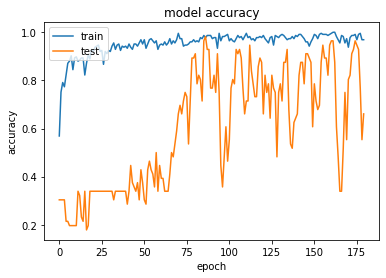

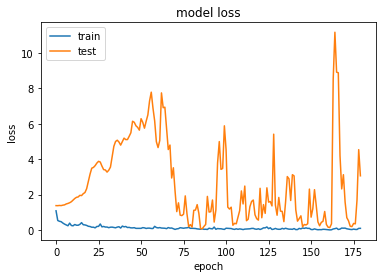

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()